|batch_size |  1            |   32          |       64  |
|---        |--             |    --         | --        |
|nfv        | 174.62+16.25  |  178.1+10.64  | 177.32+7.94 |
|vec-nfv    | 173.42+14.94  |  173.98+2.65  |173.93+1.75| 

In [36]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
from configs.ve import cifar10_ncsnpp_continuous as configs
from sde_lib import VESDE
from models import ncsnpp
from env import RK45Env
import models.utils as mutils
import torch
import numpy as np
import sampling
import datasets
from utils import restore_checkpoint
from models.ema import ExponentialMovingAverage
from losses import get_optimizer

def image_grid(x):
  size = config.data.image_size
  channels = config.data.num_channels
  img = x.reshape(-1, size, size, channels)
  w = int(np.sqrt(img.shape[0]))
  img = img[:w*w].reshape((w, w, size, size, channels)).transpose((0, 2, 1, 3, 4)).reshape((w * size, w * size, channels))
  return img

def show_samples(x):
  x = x.permute(0, 2, 3, 1).detach().cpu().numpy()
  img = image_grid(x)
  plt.figure(figsize=(8,8))
  plt.axis('off')
  plt.imshow(img)
  plt.show()


ckpt_filename = "exp/ve/cifar10_ncsnpp_continuous/checkpoint_24.pth"
config = configs.get_config()  
sde = VESDE(sigma_min=config.model.sigma_min, sigma_max=config.model.sigma_max, N=config.model.num_scales)
score_model = mutils.create_model(config)
optimizer = get_optimizer(config, score_model.parameters())
ema = ExponentialMovingAverage(score_model.parameters(),
                               decay=config.model.ema_rate)
state = dict(step=0, optimizer=optimizer,
             model=score_model, ema=ema)

state = restore_checkpoint(ckpt_filename, state, config.device)
ema.copy_to(score_model.parameters())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.031501014..1.0285841].


178.8125


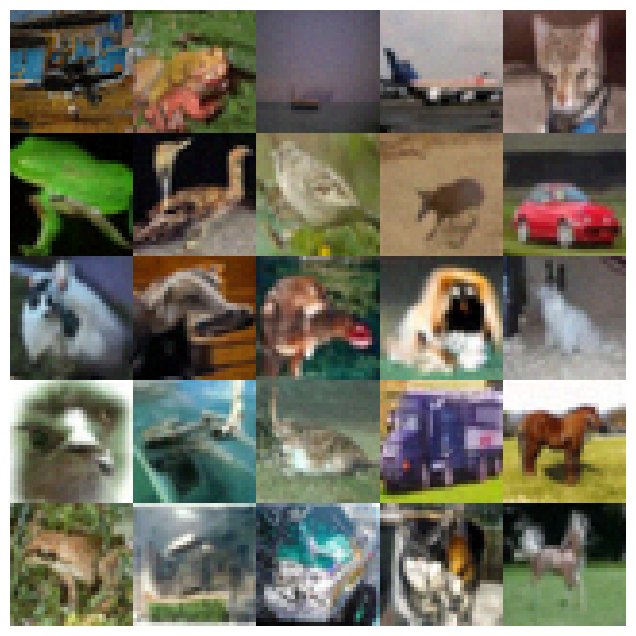

In [38]:
env = RK45Env(
    sde=sde, 
    model=score_model, 
    env_num=32, 
    device=torch.device("cuda"), 
    compute_logp=False,
)
# a = torch.randn(1, 3, 32, 32)
# torch.save(a, "z.pt")
out = env.sample()
print(out["nfev"].mean().item())
show_samples(out["z"])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.10239033..1.0617174].


mean nfev: 173.9328125+1.7525671739533268


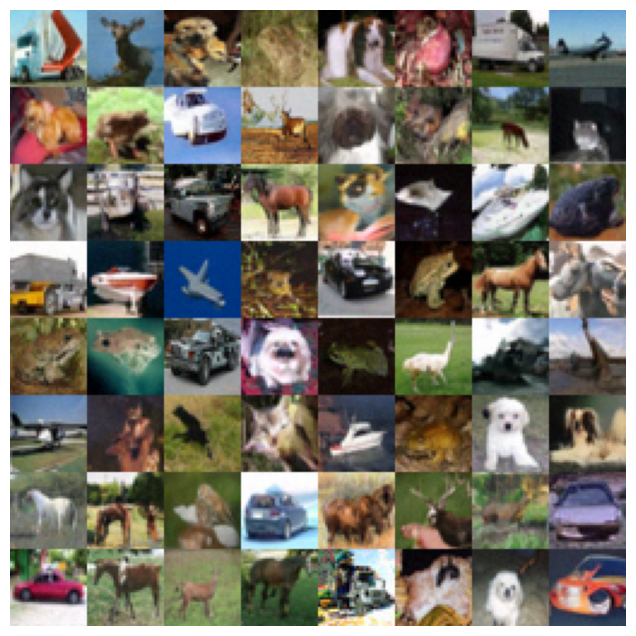

In [12]:
env = RK45Env(
    sde=sde, 
    model=score_model, 
    env_num=64, 
    device=torch.device("cuda"), 
    compute_logp=False,
    use_opt=True, 
)
def cb(env, td):
    # print(f"nfev: {env.nfev.mean().item()}, done: {td["done"].sum().item()}, rejected: {td["step_rejected"].sum().item()}")
    pass
nfevs = []
for i in range(100):
    td = env.sample(cb)
    nfevs.append(td["nfev"].mean().item())
print(f"mean nfev: {np.mean(nfevs)}+{np.std(nfevs)}") # 185.3
show_samples(td["z"])

In [14]:
shape = (64, 3, 32, 32)
scaler = datasets.get_data_scaler(config)
inverse_scaler = datasets.get_data_inverse_scaler(config)
sampling_eps = 1e-5

sampling_fn = sampling.get_ode_sampler(sde,                                        
                                       shape, 
                                       inverse_scaler,                                       
                                       denoise=True, 
                                       eps=sampling_eps,
                                       device=config.device)
nfevs = []
for i in range(100):
    x, nfe = sampling_fn(score_model)
    nfevs.append(nfe)
print(f"mean nfev: {np.mean(nfevs)}+{np.std(nfevs)}") # 174.62+16.252249075128034
# show_samples(x)

mean nfev: 177.32+7.940881563151537


In [19]:
scaler = datasets.get_data_scaler(config)
inverse_scaler = datasets.get_data_inverse_scaler(config)
sampling_eps = 1e-5

sampling_fn = sampling.get_ode_sampler(sde,                                        
                                       (32, 3, 32, 32), 
                                       inverse_scaler,                                       
                                       denoise=True, 
                                       eps=sampling_eps,
                                       device=config.device)
x, nfe = sampling_fn(score_model)
print(nfe)

170
